In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

The project follows this tutorial https://www.tensorflow.org/tutorials/images/classification 

This project uses a dataset of animal photos. The dataset contains five sub-directories, one per class:

location = D:\datasets\iNaturalCleaned

```
D:\datasets\iNaturalCleaned\blackBear
D:\datasets\iNaturalCleaned\coyote
D:\datasets\iNaturalCleaned\ruffedGrouse
D:\datasets\iNaturalCleaned\turkey
D:\datasets\iNaturalCleaned\whitetailDeer
```

Total number of images: 47000


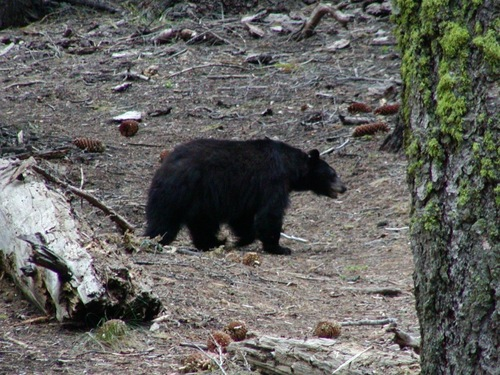

In [3]:
# Specify the location of your dataset
data_dir = pathlib.Path(r'D:\datasets\trailSortData')

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total number of images: {image_count}")

# Example: Load and display an image from the 'blackBear' folder
black_bears = list(data_dir.glob('blackBear/*'))
PIL.Image.open(str(black_bears[0]))

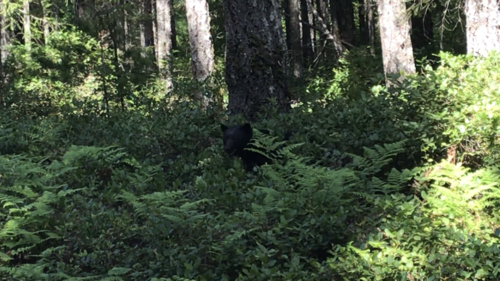

In [5]:
PIL.Image.open(str(black_bears[6000]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 47000 files belonging to 5 classes.
Using 37600 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 47000 files belonging to 5 classes.
Using 9400 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [7]:
class_names = train_ds.class_names
print(class_names)

['blackBear', 'coyote', 'ruffedGrouse', 'turkey', 'whitetailDeer']


## Visualize the data


Here are the first nine images from the training dataset:

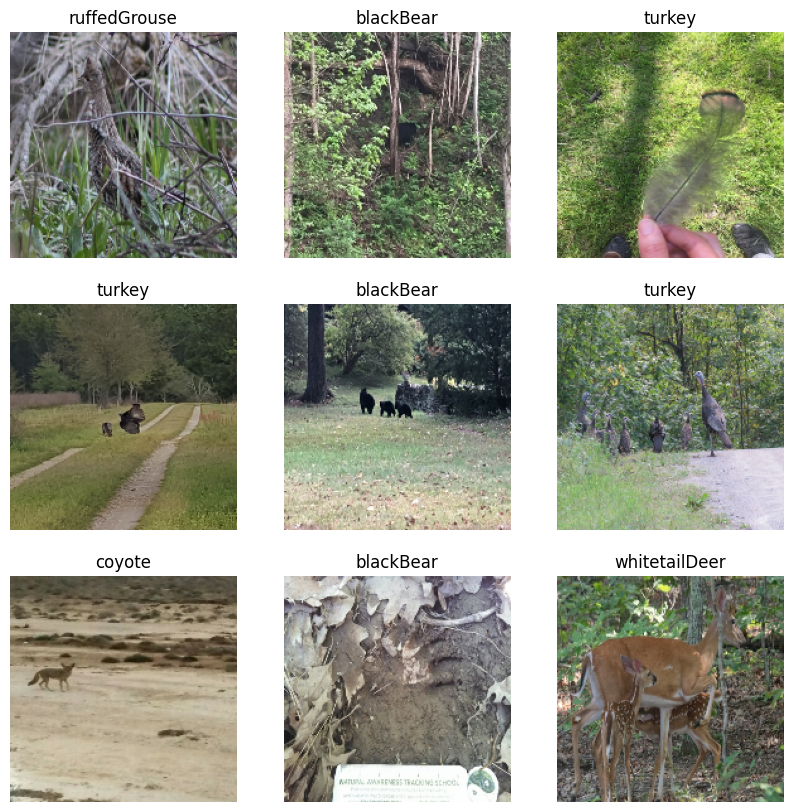

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [9]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99999183


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

The first layer is the input layer
```layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))```
height = 180, width = 180, and 3 refers to RGB - Input layer is 180x180x3 = 97,200 number of input nodes

We than rescale that value for the pixels to have a value between [0,1] and not [0,255]

The basis of the work done here is that the image is passed through a convolutional layer which is where the learning of the important aspects of the images happens. The two-dimensional convolution layer has parameters as (16, 3, padding='same', activation='relu'). The first is for how many filters to use (16). The next is the kernel size which is the size of the convolution window (3 for a 3x3). After that we set padding to same so the output has the same size of the input (180, 180, 16) as seen in our model summary. Lastly, the activation function defines how the output of a layer. The ‘relu’ just says that if it is a negative value, convert it to zero. This is followed by a max pooling layer where the size is reduced, lowering the cost of computation, but still trying to retain those important aspects and features from the previous layer. You can see the output becomes halved in the summary at (90, 90, 16). This process is repeated.

The flatten layer takes the 22x22x64 and flattens it from three dimensions to a one-dimension array of 30,976. The dense layer then helps the model learn the high-level representations of the images and converts it to just 128 nodes. The step is repeated to get the final output as the five classes I created for deer, turkey, beer, grouse, and coyotes.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch is a complete pass through of the dataset. The model processes all the training samples at once and updates it weights. Multiple epochs allows the model to learn better representations from the data.

Training data is 37,600 images and batch size is 32. 37,600/32 = 1175 Epoch size (steps).

The smaller the batch size, the more increase the generalization becomes. Smaller bacth sizes can also slow down the training.

```
Epoch 1/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 515s 234ms/step - accuracy: 0.3011 - loss: 1.5591 - val_accuracy: 0.4123 - val_loss: 1.3716
Epoch 2/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 170s 145ms/step - accuracy: 0.4438 - loss: 1.3173 - val_accuracy: 0.4520 - val_loss: 1.3081
Epoch 3/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 168s 143ms/step - accuracy: 0.5417 - loss: 1.1371 - val_accuracy: 0.4637 - val_loss: 1.3012
Epoch 4/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 165s 140ms/step - accuracy: 0.6625 - loss: 0.8678 - val_accuracy: 0.4744 - val_loss: 1.3980
Epoch 5/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 162s 138ms/step - accuracy: 0.7942 - loss: 0.5659 - val_accuracy: 0.4533 - val_loss: 1.8313
Epoch 6/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 170s 144ms/step - accuracy: 0.8927 - loss: 0.3150 - val_accuracy: 0.4450 - val_loss: 2.3093
Epoch 7/10
 449/1175 ━━━━━━━━━━━━━━━━━━━━ 1:27 121ms/step - accuracy: 0.9454 - loss: 0.1824
```

I noticed the same pattern as before but this time using a larger dataset. I decided to stop the training and move to the next setup.

The increase in accuracy but decrease in validation accuracy is said to be a sign of overfitting or can also be a sign that the dataset is to complex for the size of the dataset that uou are using to train it.

Solutions

- Increase dataset size (artifically using data augmenation if can not get mroe data)
- Stop early when validation accuracy starts to dip

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

Increased levels of random rotation and zoom as well as added contrast.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

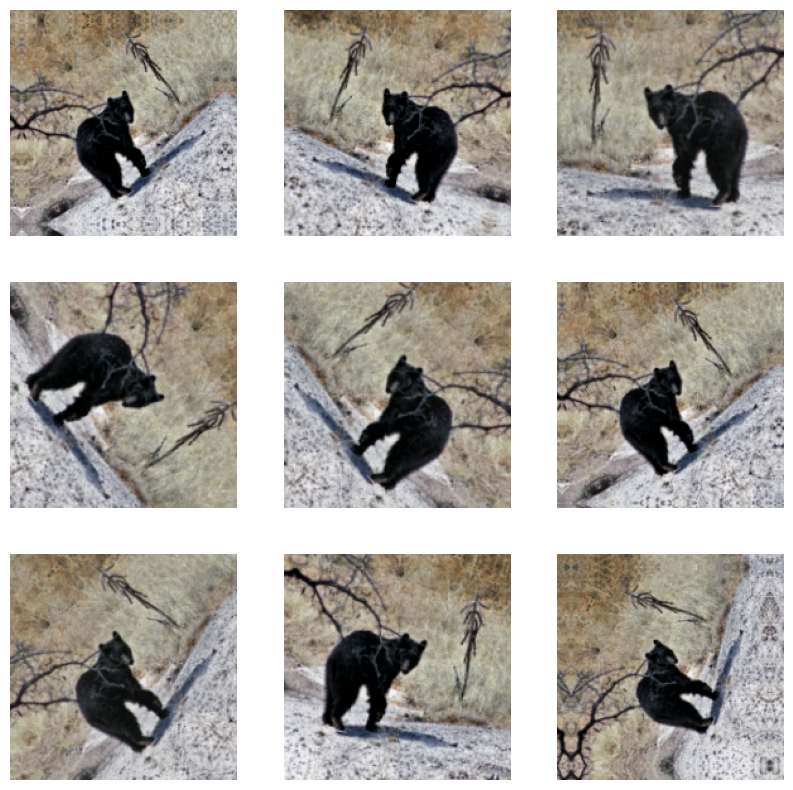

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

Overfitting could be seen by visualizing the training accuracy and the validation accuracy of models after training. Overfitting is when “the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.” (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). To help with overfitting a common tactic is using dropout. Dropout randomly selects a number of nodes / neurons and sets them to zero to deactivate them. For example, with ‘layers.Dropout(0.2),’ 20% of the neurons in the layer are randomly dropped during each training step, meaning 80% of the neurons remain active. This helps prevents overfitting by randomly deactivating neurons during training which forces the model to not rely on any specific set of nodes. That helps generalize better and encourages the model to learn more robust features that are not dependent on the presence of any specific node.

Increase the dropout to 40%. Added L2 Regularization parameter to help penilize large weights and hope to help with the overfitting problem.

In [21]:
num_classes = len(class_names)

from tensorflow.keras import regularizers

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu', 
                 kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.Dense(num_classes, name="outputs")  # Output layer, no regularization
])


## Compile and train the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


1175/1175 ━━━━━━━━━━━━━━━━━━━━ 207s 174ms/step - accuracy: 0.2723 - loss: 1.6527 - val_accuracy: 0.3518 - val_loss: 1.5188
Epoch 2/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 208s 177ms/step - accuracy: 0.3446 - loss: 1.5340 - val_accuracy: 0.3687 - val_loss: 1.5064
Epoch 3/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 211s 180ms/step - accuracy: 0.3715 - loss: 1.4982 - val_accuracy: 0.3631 - val_loss: 1.5338
Epoch 4/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 205s 174ms/step - accuracy: 0.3806 - loss: 1.4860 - val_accuracy: 0.3721 - val_loss: 1.4763
Epoch 5/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 216s 184ms/step - accuracy: 0.3950 - loss: 1.4710 - val_accuracy: 0.3851 - val_loss: 1.4835
Epoch 6/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 211s 179ms/step - accuracy: 0.3953 - loss: 1.4675 - val_accuracy: 0.3448 - val_loss: 1.6212
Epoch 7/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 209s 178ms/step - accuracy: 0.3939 - loss: 1.4657 - val_accuracy: 0.4011 - val_loss: 1.4492
Epoch 8/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 210s 179ms/step - accuracy: 0.4

Epoch 1/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 207s 174ms/step - accuracy: 0.2723 - loss: 1.6527 - val_accuracy: 0.3518 - val_loss: 1.5188

Epoch 2/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 208s 177ms/step - accuracy: 0.3446 - loss: 1.5340 - val_accuracy: 0.3687 - val_loss: 1.5064

Epoch 3/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 211s 180ms/step - accuracy: 0.3715 - loss: 1.4982 - val_accuracy: 0.3631 - val_loss: 1.5338

Epoch 4/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 205s 174ms/step - accuracy: 0.3806 - loss: 1.4860 - val_accuracy: 0.3721 - val_loss: 1.4763

Epoch 5/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 216s 184ms/step - accuracy: 0.3950 - loss: 1.4710 - val_accuracy: 0.3851 - val_loss: 1.4835

Epoch 6/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 211s 179ms/step - accuracy: 0.3953 - loss: 1.4675 - val_accuracy: 0.3448 - val_loss: 1.6212

Epoch 7/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 209s 178ms/step - accuracy: 0.3939 - loss: 1.4657 - val_accuracy: 0.4011 - val_loss: 1.4492

Epoch 8/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 210s 179ms/step - accuracy: 0.4020 - loss: 1.4594 - val_accuracy: 0.3901 - val_loss: 1.4888

Epoch 9/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 218s 186ms/step - accuracy: 0.4060 - loss: 1.4528 - val_accuracy: 0.3882 - val_loss: 1.5149

Epoch 10/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 236s 201ms/step - accuracy: 0.4024 - loss: 1.4595 - val_accuracy: 0.3990 - val_loss: 1.4715

Epoch 11/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 236s 201ms/step - accuracy: 0.4146 - loss: 1.4456 - val_accuracy: 0.4328 - val_loss: 1.4173

Epoch 12/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 238s 203ms/step - accuracy: 0.4156 - loss: 1.4449 - val_accuracy: 0.4043 - val_loss: 1.4479

Epoch 13/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 235s 200ms/step - accuracy: 0.4222 - loss: 1.4412 - val_accuracy: 0.4103 - val_loss: 1.4617

Epoch 14/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 222s 189ms/step - accuracy: 0.4162 - loss: 1.4413 - val_accuracy: 0.4465 - val_loss: 1.4002

Epoch 15/15
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 210s 179ms/step - accuracy: 0.4217 - loss: 1.4373 - val_accuracy: 0.4331 - val_loss: 1.4209

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

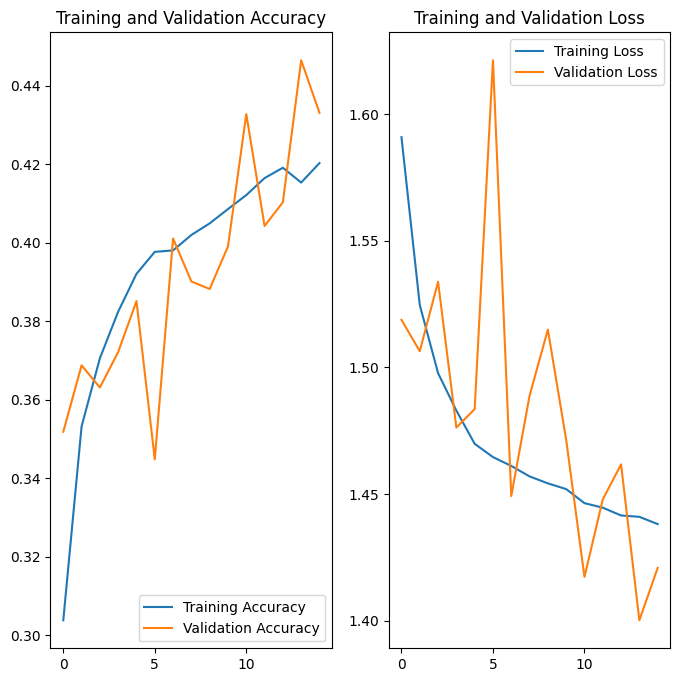

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

Test out different animal images here

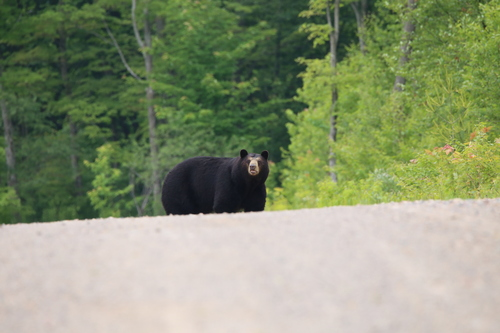

In [26]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('blackBear/*'))
test_image_path = (test_image[5654])
PIL.Image.open(str(test_image[5654]))

In [27]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
This image most likely belongs to blackBear with a 55.41 percent confidence.


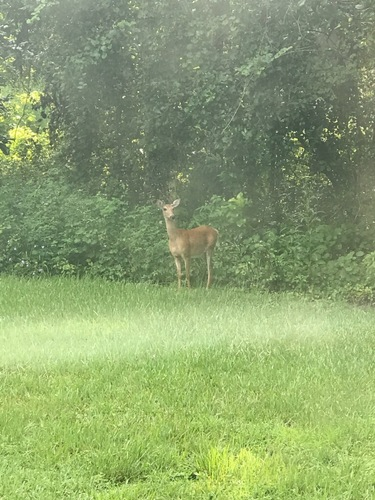

In [28]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('whitetailDeer/*'))
test_image_path = (test_image[5601])
PIL.Image.open(str(test_image[5601]))

In [29]:

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image most likely belongs to coyote with a 37.03 percent confidence.


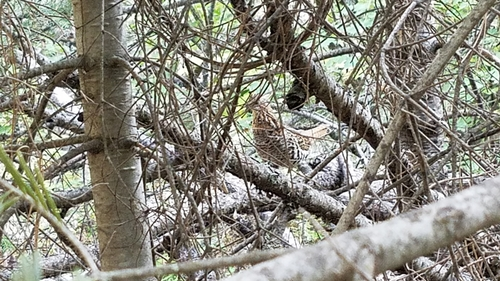

In [34]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('ruffedGrouse/*'))
test_image_path = (test_image[5667])
PIL.Image.open(str(test_image[5667]))

In [35]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
This image most likely belongs to ruffedGrouse with a 37.10 percent confidence.


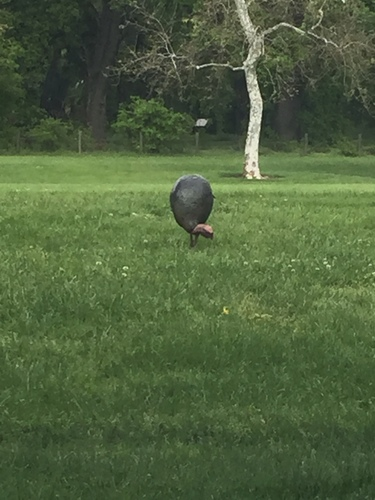

In [36]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('turkey/*'))
test_image_path = (test_image[5655])
PIL.Image.open(str(test_image[5655]))

In [37]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
This image most likely belongs to turkey with a 46.69 percent confidence.


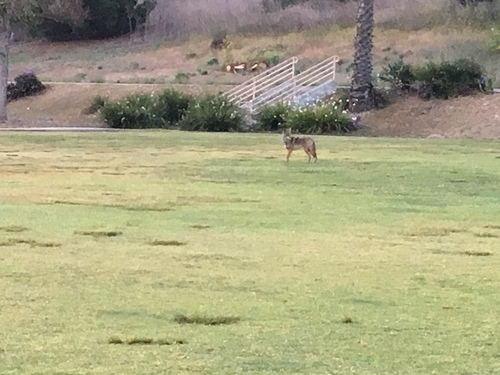

In [38]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('coyote/*'))
test_image_path = (test_image[5604])
PIL.Image.open(str(test_image[5604]))

In [39]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
This image most likely belongs to coyote with a 54.94 percent confidence.


## Save base model

In [ ]:
# Save the model
model.save(r'C:\Users\kdlor\Documents\Documents\projects\TrailSort\trainingTrailSort\models\trailSortTF3Large.keras')



## Running Model

### Load the Model

In [41]:
import tensorflow as tf

# Load the model
savedModel = tf.keras.models.load_model(r'C:\Users\kdlor\Documents\Documents\projects\TrailSort\trainingTrailSort\models\trailSortTF3Large.keras')
savedModel.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,967,857 (45.65 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,978,572 (30.44 MB)

### Prepare Input Data

You need to preprocess the input data (images) similarly to how you did when training the model. This typically includes resizing the image and normalizing pixel values.

In [42]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    return img_array


### Predictions

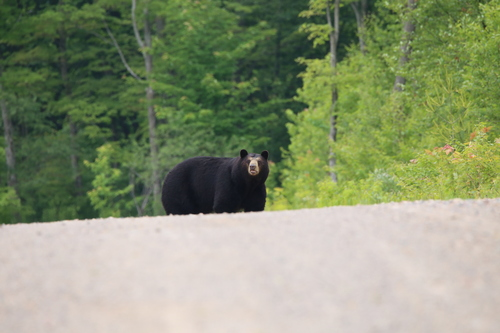

In [43]:
import os
import pathlib
import PIL

img_height = 180
img_width = 180
# Define the target size as per your model's input shape
target_size = (img_height, img_width)  # Set this according to your model

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('blackBear/*'))
test_image_path = (test_image[5654])
PIL.Image.open(str(test_image[5654]))



In [44]:
# class_names = 0,1,2,3,4, - blackBear,coyote,ruffedGrouse,turkey,whitetailDeer
class_names = ["blackBear", "coyote", "ruffedGrouse", "turkey", "whitetailDeer"]

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = savedModel.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
This image most likely belongs to blackBear with a 55.41 percent confidence.


## More epochs and layers.

In [12]:
num_classes = len(class_names)

from tensorflow.keras import regularizers

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax') 
])



In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Default is from_logits=False
    metrics=['accuracy']
)


In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,637 (7.94 MB)

 Trainable params: 2,081,157 (7.94 MB)

 Non-trainable params: 480 (1.88 KB)

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 780s 466ms/step - accuracy: 0.2147 - loss: 2.2508 - val_accuracy: 0.2081 - val_loss: 1.7895
Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 476s 405ms/step - accuracy: 0.2139 - loss: 1.7518 - val_accuracy: 0.2082 - val_loss: 1.6637
Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 464s 395ms/step - accuracy: 0.2115 - loss: 1.6555 - val_accuracy: 0.2082 - val_loss: 1.7498
Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 463s 394ms/step - accuracy: 0.2131 - loss: 1.6911 - val_accuracy: 0.2159 - val_loss: 1.6138
Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 467s 398ms/step - accuracy: 0.2099 - loss: 1.6829 - val_accuracy: 0.2082 - val_loss: 1.6576
Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 466s 396ms/step - accuracy: 0.2125 - loss: 1.6380 - val_accuracy: 0.2159 - val_loss: 1.6082
Epoch 7/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 461s 392ms/step - accuracy: 0.2100 - loss: 1.6082 - val_accuracy: 0.2141 - val_loss: 1.6014
Epoch 8/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 461s 392ms/step - ac

Epoch 1/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 780s 466ms/step - accuracy: 0.2147 - loss: 2.2508 - val_accuracy: 0.2081 - val_loss: 1.7895

Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 476s 405ms/step - accuracy: 0.2139 - loss: 1.7518 - val_accuracy: 0.2082 - val_loss: 1.6637

Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 464s 395ms/step - accuracy: 0.2115 - loss: 1.6555 - val_accuracy: 0.2082 - val_loss: 1.7498

Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 463s 394ms/step - accuracy: 0.2131 - loss: 1.6911 - val_accuracy: 0.2159 - val_loss: 1.6138

Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 467s 398ms/step - accuracy: 0.2099 - loss: 1.6829 - val_accuracy: 0.2082 - val_loss: 1.6576

Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 466s 396ms/step - accuracy: 0.2125 - loss: 1.6380 - val_accuracy: 0.2159 - val_loss: 1.6082

Epoch 7/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 461s 392ms/step - accuracy: 0.2100 - loss: 1.6082 - val_accuracy: 0.2141 - val_loss: 1.6014

Epoch 8/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 461s 392ms/step - accuracy: 0.2130 - loss: 1.6032 - val_accuracy: 0.2082 - val_loss: 1.6000

Epoch 9/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 463s 394ms/step - accuracy: 0.2093 - loss: 1.6022 - val_accuracy: 0.2082 - val_loss: 1.5993

Epoch 10/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 467s 397ms/step - accuracy: 0.2092 - loss: 1.6022 - val_accuracy: 0.2082 - val_loss: 1.5990

Epoch 11/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 459s 391ms/step - accuracy: 0.2156 - loss: 1.6017 - val_accuracy: 0.2082 - val_loss: 1.5990

Epoch 12/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 459s 391ms/step - accuracy: 0.2092 - loss: 1.6018 - val_accuracy: 0.2082 - val_loss: 1.5990

Epoch 13/20

...

Epoch 19/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 464s 395ms/step - accuracy: 0.2141 - loss: 1.6020 - val_accuracy: 0.2082 - val_loss: 1.5990

Epoch 20/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 450s 383ms/step - accuracy: 0.2195 - loss: 1.6022 - val_accuracy: 0.2159 - val_loss: 1.5989

### Back to the one with the best results but keeping the epochs increased.

In [16]:
num_classes = len(class_names)

from tensorflow.keras import regularizers

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu', 
                 kernel_regularizer=regularizers.L2(0.001)),  # L2 regularization
    layers.Dense(num_classes, name="outputs")  # Output layer, no regularization
])


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 202s 170ms/step - accuracy: 0.2848 - loss: 1.6369 - val_accuracy: 0.3595 - val_loss: 1.5152
Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 198s 169ms/step - accuracy: 0.3536 - loss: 1.5210 - val_accuracy: 0.3377 - val_loss: 1.5529
Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 197s 168ms/step - accuracy: 0.3662 - loss: 1.4993 - val_accuracy: 0.3662 - val_loss: 1.5125
Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 192s 163ms/step - accuracy: 0.3777 - loss: 1.4879 - val_accuracy: 0.3939 - val_loss: 1.4620
Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 191s 163ms/step - accuracy: 0.3847 - loss: 1.4723 - val_accuracy: 0.4111 - val_loss: 1.4450
Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 195s 166ms/step - accuracy: 0.4034 - loss: 1.4591 - val_accuracy: 0.3999 - val_loss: 1.4468
Epoch 7/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 192s 164ms/step - accuracy: 0.4007 - loss: 1.4603 - val_accuracy: 0.3943 - val_loss: 1.4716
Epoch 8/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 191s 162ms/step - ac

Epoch 1/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 202s 170ms/step - accuracy: 0.2848 - loss: 1.6369 - val_accuracy: 0.3595 - val_loss: 1.5152

Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 198s 169ms/step - accuracy: 0.3536 - loss: 1.5210 - val_accuracy: 0.3377 - val_loss: 1.5529

Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 197s 168ms/step - accuracy: 0.3662 - loss: 1.4993 - val_accuracy: 0.3662 - val_loss: 1.5125

Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 192s 163ms/step - accuracy: 0.3777 - loss: 1.4879 - val_accuracy: 0.3939 - val_loss: 1.4620

Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 191s 163ms/step - accuracy: 0.3847 - loss: 1.4723 - val_accuracy: 0.4111 - val_loss: 1.4450

Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 195s 166ms/step - accuracy: 0.4034 - loss: 1.4591 - val_accuracy: 0.3999 - val_loss: 1.4468

Epoch 7/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 192s 164ms/step - accuracy: 0.4007 - loss: 1.4603 - val_accuracy: 0.3943 - val_loss: 1.4716

Epoch 8/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 191s 162ms/step - accuracy: 0.4028 - loss: 1.4580 - val_accuracy: 0.3746 - val_loss: 1.5193

Epoch 9/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 190s 162ms/step - accuracy: 0.4116 - loss: 1.4508 - val_accuracy: 0.4259 - val_loss: 1.4287

Epoch 10/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 190s 162ms/step - accuracy: 0.4086 - loss: 1.4536 - val_accuracy: 0.4327 - val_loss: 1.4156

Epoch 11/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 190s 161ms/step - accuracy: 0.4185 - loss: 1.4441 - val_accuracy: 0.4314 - val_loss: 1.4126

Epoch 12/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 191s 163ms/step - accuracy: 0.4091 - loss: 1.4481 - val_accuracy: 0.4168 - val_loss: 1.4514

Epoch 13/20

...

Epoch 19/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 193s 164ms/step - accuracy: 0.4310 - loss: 1.4277 - val_accuracy: 0.4152 - val_loss: 1.4508

Epoch 20/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 193s 164ms/step - accuracy: 0.4242 - loss: 1.4312 - val_accuracy: 0.4350 - val_loss: 1.4066